In [1]:
import torch
from dataset import ImageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import torch.optim as optim
import torch.nn as nn
import numpy as np
from utils_cells import calculate_precision_recall_per_class, get_accuracies_per_class
import sys
from vit import VisionTransformer
import time
import pandas as pd
from torchmetrics import Precision, Recall
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.mode.chained_assignment = 'warn'
torch.cuda.empty_cache()

model = VisionTransformer(image_size=32, in_channels=4, num_classes=4, hidden_dims=[16, 16])


batch_size = 64

trainset = ImageDataset(data_path='train_data')
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=5)


testset =ImageDataset(data_path='validation_data')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=5)

model = model.to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


precisions = []
precisions_val = []


recalls = []
val_recalls = []

losses = []
val_losses = []



metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

metric_precision_val = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
metric_recall_val = Recall(task="multiclass", num_classes=4, average=None).to('cuda')

In [3]:
for epoch in range(20):
    recall = []
    precision = []

    recall_val = []
    precision_val = []

    training_loss = []
    start_time = time.time()
    elapsed_time = 0
    model.train() 
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        inputs, labels = data
        labels = torch.Tensor(labels)
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)


        metric_precision(outputs, labels)
        metric_recall(outputs, labels)



        loss.backward()
        optimizer.step()
        
        training_loss.append(loss.item())

        if (i + 1) % 100 == 0 or i == len(trainloader) - 1:
            elapsed_time = time.time() - start_time
            batches_done = i + 1
            batches_total = len(trainloader)
            batches_remaining = batches_total - batches_done
            time_per_batch = elapsed_time / batches_done
            estimated_time_remaining = time_per_batch * batches_remaining

            elapsed_time_minutes = elapsed_time / 60
            estimated_time_remaining_minutes = estimated_time_remaining / 60

            progress_message = f'Batch {i}/{len(trainloader)},Remaining: {estimated_time_remaining_minutes:.2f}min'
            sys.stdout.write("\r" + progress_message)
            sys.stdout.flush()

        

 
    model.eval()  
    val_loss = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            labels = torch.Tensor(labels)
            inputs = inputs.to('cuda:0')
            labels = labels.to('cuda:0')


            outputs = model(inputs)
            val_loss_crt = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            metric_precision_val(outputs, labels)
            metric_recall_val(outputs, labels)


            val_loss.append(val_loss_crt.item())

    precision = metric_precision.compute()
    recall = metric_recall.compute()

    precision_val = metric_precision_val.compute()
    recall_val = metric_recall_val.compute()

    precisions.append(precision)
    precisions_val.append(precision_val)

    recalls.append(recall)
    val_recalls.append(recall_val)
    
    losses.append(np.mean(training_loss))
    val_losses.append(np.mean(val_loss))
    
    print(f'Epoch {epoch + 1}, Training loss: {np.mean(training_loss)} Validation Loss: {np.mean(val_loss)}')
    
    print(f'Epoch {epoch + 1}, Training Class 1: {precision[0]}, Class 2: {precision[1]}, Class 3: {precision[2]}, Class 4: {precision[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {precision_val[0]}, Class 2: {precision_val[1]}, Class 3: {precision_val[2]}, Class 4: {precision_val[3]}')

    print(f'Epoch {epoch + 1}, Training Class 1: {recall[0]}, Class 2: {recall[1]}, Class 3: {recall[2]}, Class 4: {recall[3]}')
    print(f'Epoch {epoch + 1}, Validation Class 1: {recall_val[0]}, Class 2: {recall_val[1]}, Class 3: {recall_val[2]}, Class 4: {recall_val[3]}')

    

print('Finished Training')
print('Finished Training')


Batch 3356/3357,Remaining: 0.00minEpoch 1, Training loss: 0.8705949934600612 Validation Loss: 0.7822337449943133
Epoch 1, Training Class 1: 0.6822026968002319, Class 2: 0.5518571138381958, Class 3: 0.6707921028137207, Class 4: 0.6521795392036438
Epoch 1, Validation Class 1: 0.6772817969322205, Class 2: 0.6089720726013184, Class 3: 0.48539209365844727, Class 4: 0.75465327501297
Epoch 1, Training Class 1: 0.7692351937294006, Class 2: 0.5287157297134399, Class 3: 0.07821068167686462, Class 4: 0.6539393663406372
Epoch 1, Validation Class 1: 0.8557239174842834, Class 2: 0.580471396446228, Class 3: 0.3188552260398865, Class 4: 0.6170370578765869
Batch 3356/3357,Remaining: 0.00minEpoch 2, Training loss: 0.7640638899014824 Validation Loss: 0.7383960575134577
Epoch 2, Training Class 1: 0.7075463533401489, Class 2: 0.5786088109016418, Class 3: 0.6209827065467834, Class 4: 0.6773152351379395
Epoch 2, Validation Class 1: 0.717879056930542, Class 2: 0.6089937090873718, Class 3: 0.4888207018375397, 

In [4]:
df = pd.DataFrame()

df['loss'] = np.array(losses)
df['val_loss'] = np.array(val_losses)

df['recall'] = [list(recall.cpu().numpy()) for recall in recalls]
df['val_recall'] = [list(val_recall.cpu().numpy()) for val_recall in val_recalls]




df.to_csv('results2.csv', index=False)

torch.save(model.state_dict(),'model_vit2.pth')


In [5]:
df = pd.read_csv('results2.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'results2.csv'

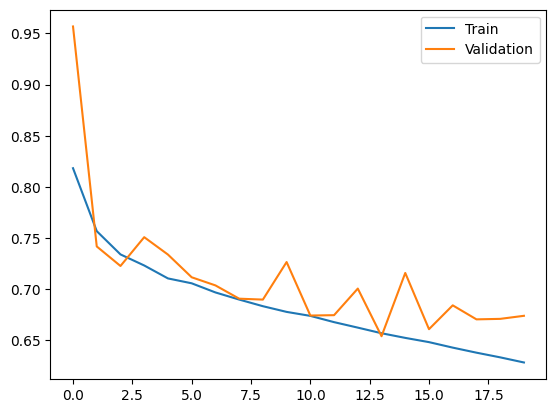

In [ ]:
plt.plot(df['loss'], label='Train')
plt.plot(df['val_loss'], label='Validation')
plt.legend()
plt.show()